# Python analysis code for the CoilQA portion of the Traveling Spine Study
## Daniel Papp, Eva Alonso-Ortiz, Polytechnique Montreal, 2023

## Expected input data structure

## This notebook expects the input data to be structured in the following way:

### All data is converted from DICOM into NIFTI format using dcm2niix, with the following flags: "-f %s_%p -z y", with the exception of the GRE scans, which are converted using the flags "-f %s_%p -z y -m o". The expected output of this are filenames that start with a number, indicating the scan number (in order of reconstruction), and continue with an alphanumeric string indicating the name of the scan. The GRE scans are adittionally converted to preserve the RX-coil uncombined reconstruction. NB! the GRE scans have to be separated and converted separately!

### For each subject, the resulting .nii.gz and .json files are then grouped into directories corresponding with the scans (so for example, the TFL_B1map scan results in three pairs of files, all of which are in one directory). Subjects are named as SubL, SubR, SubD, or Spinoza6, respectively. RF shimmed acquisitions, if they exist, are put into an RFSHIM subdirectory.



### The subjects are grouped according to the site of data acquisition.

### The end result is, for SubL acquired at site MGH, the following:
#### MGH
####         SubL
####                  COILQA_SAG_LARGE
####                  COILQA_SAG_SMALL
####                  COILQA_TRA
####                  DREAM_LARGE
####                  DREAM_MEDIUM
####                  DREAM_MEDIUM_066  ---> this scan is the one acquired with 66.6% of the optimal Reference Voltage
####                  DREAM_MEDIUM_HWLIMIT  ---> this scan is the one acquired with the hardware limit Reference Voltage. In case that 150% of the reference Voltage would be possible to acquire, this would be called DREAM_MEDIUM_150
####                  GRE ---> this folder contains both the combined and uncombined scans
####                  MP2RAGE
####                  TFL_B1 ---> this folder contains the B1+ map acquired without the Optimal Reference Voltage
####                  TFL_B1_C3C4 ---> This folder contains the B1+ map acquired with the Optimal Reference Voltage
####                  TFL_RFMAP ---> This folder is optional and is comes from in the RF shimming step
####                  RFSHIM ---> This folder contains the B1+ shimmed scans, wich always include the following:
####                                COILQA_SAG_LARGE ---> Same scan as the first folder, but acquired using RF shimming
####                                GRE ---> Same scan as the unshimmed GRE folder, but acquired using RF shimming
####                                TFL_RFMAP ---> Acquired using RF shimming


## Sanity checks

### There is currently one sanity check in the notebook, using the function "RefVolChecker". This will print to a table the reference voltage of each scan, and check wether they have been acquired using the Optimal Reference Voltage, which is defined as the Reference Voltage of the TFL_B1_C3C4 scan.

### Another sanity check might be needed to check Table Positions, but that requires working on the DICOM data

## Processing notes

### In order to keep processed and unprocessed data separate, all processed data is stored under a "PROCESSING" master directory, where the directory strucutre of the original data is preserved. That is, when processing THS_DATA/MGH/SubL/MP2RAGE, all processed data, all segmentation, etc, etc, will be put under /THS_DATA/PROCESSING/MGH/SubL/MP2RAGE

### The notebook is configured such that each scan of each subject can be analyzed independently








# Initial setup: Imports and installs

In [1]:
#Initial setup: importing modules
import os
import re
import json
import subprocess
import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display
from tabulate import tabulate
import nibabel as nib
import pandas as pd



In [79]:
from IPython.display import clear_output
import sys

# Ask user for OSF login information
osf_username = input("Enter OSF username: ")
osf_password = input("Enter OSF password: ")
%env OSF_USERNAME={osf_username}
%env OSF_PASSWORD={osf_password}

sys.stdout.flush()
clear_output()
sys.stdout.flush()

sites_dict = {
    "MGH": "kgsbz",
    "MNI": "5qapx",
}

site_selection_text = ""
for site_index, site_name in enumerate(sites_dict.keys()):
    site_selection_text += str(site_index) + " - " + site_name + "\n"
site_selection_text += "Enter site index: "
site_name = list(sites_dict.keys())[int(input(site_selection_text))]

# osfclient installation from GitHub
! git clone https://github.com/osfclient/osfclient
! pip install /content/osfclient
print("osfclient installed")

# Downloading data archive from OSF using osfclient
archive = "/content/osfclient/" + site_name + ".zip"
! osf -p {sites_dict[site_name]} fetch /{site_name}.zip {archive}

# Unzipping archive
import zipfile
with zipfile.ZipFile(archive, "r") as zip_ref:
    zip_ref.extractall("/content/Traveling_Spines_7T/")

print("Downloaded files from OSF")

0 - MGH
1 - MNI
Enter site index: 1
fatal: destination path 'osfclient' already exists and is not an empty directory.
Processing ./osfclient
  Preparing metadata (setup.py) ... done
  Created wheel for osfclient: filename=osfclient-0.0.5-py2.py3-none-any.whl size=39122 sha256=bc98cb643de1df4e01b971ea466648271c065fd4520e3968a6be518c82f14d5c
  Stored in directory: /tmp/pip-ephem-wheel-cache-d3_v95to/wheels/1a/0f/f5/1da2c993dcd84616a4e7a3f95d95002e47c6863b0d72c51b0d
Successfully built osfclient
  Attempting uninstall: osfclient
    Found existing installation: osfclient 0.0.5
    Uninstalling osfclient-0.0.5:
      Successfully uninstalled osfclient-0.0.5
osfclient installed
100% 814M/814M [00:11<00:00, 69.2Mbytes/s]
Downloaded files from OSF


In [80]:
import os
import numpy as np

# Spinal cord toolbox (SCT): This tool is used to for most of our processing, including image registration
# Website: https://spinalcordtoolbox.com/
!git clone --depth 1 --branch 5.3.0 https://github.com/spinalcordtoolbox/spinalcordtoolbox /content/spinalcordtoolbox
os.chdir("/content/spinalcordtoolbox")
!yes | /content/spinalcordtoolbox/install_sct
os.environ["PATH"] += ":/content/spinalcordtoolbox/bin"
os.environ["SCT_DIR"] = "/content/spinalcordtoolbox"
os.chdir("/")
print("SCT installed")

# NIIMATH: since the sct_math function used in the "Registration to PAM50 template" is configured for 3D images, niimath
# is used to perform a few image operations on 4D images
# Github: https://github.com/rordenlab/niimath
os.chdir("/content/")
!curl -fLO https://github.com/rordenlab/niimath/releases/download/v1.0.20211212/niimath_lnx.zip
os.makedirs("/content/niimath/", exist_ok=True)
!unzip -o niimath_lnx.zip -d /content/niimath
os.environ["PATH"] += ":/content/niimath"
os.environ["FSLOUTPUTTYPE"] = "NIFTI_GZ"
print("NIIMATH installed")

fatal: destination path '/content/spinalcordtoolbox' already exists and is not an empty directory.


*******************************
* Welcome to SCT installation *
*******************************



Checking OS type and version...

Linux fda5fd1e5cf6 5.15.120+ #1 SMP Wed Aug 30 11:19:59 UTC 2023 x86_64 x86_64 x86_64 GNU/Linux

Checking requirements...


OK!


SCT version ......... 5.3.0
Installation type ... in-place
Operating system .... linux (unknown)
Shell config ........ /root/.bashrc

To improve user experience and fix bugs, the SCT development team is using a
report system to automatically receive crash reports and errors from users.
These reports are anonymous.

Do you agree to help us improve SCT? [y]es/[n]o: 
--> Crash reports will be sent to the SCT development team. Thank you!


SCT will be installed here: [/content/spinalcordtoolbox]



Do you agree? [y]es/[n]o: 
Do you want to add the sct_* scripts to your PATH environment? [y]es/[n]o: 
Skipping copy of source files (sou

## Helper functions

### Helper functions are collected here

### find_scan_dir will return the path of any scan, as long as it exists

### find_matching_nii_json_pairs will return the nifti file corresponding to a JSON with a specific keyword-location  info. For example, to get the UNI image of the MP2RAGE scan, the keyword would be 'UNI' and the keywordlocation would be 'ImageType'

### run_subprocess is just a wrapper to run subprocesses (that is, calls to sct, niimath, etc) with a bit more convenience. NB! output is MUTED unless an errror occurs!

In [81]:
# Helper function to return the directory path of a specific scan. Expected inputs are the root path (so either
# THS_DATA or PROCESSING), the site name (MGH, MNI, NTNU, etc), the subject name (SubL, SubR, SubD, Sinoza6) and the name
# of the scan directory

def find_scan_dir(root_dir, site_name, subject_name, scan_name):
    for root, dirs, files in os.walk(root_dir):
        if site_name in dirs:
            site_path = os.path.join(root, site_name)
            subject_path = os.path.join(site_path, subject_name)
            scan_path = os.path.join(subject_path, scan_name)
            if os.path.exists(scan_path):
                return scan_path
            else:
                return f"Error: {scan_name} not found in {subject_name}"
        else:
            return f"Error: {subject_name} not found in {site_name}"
    return f"Error: {site_name} not found"


# Helper function to find a specific string in a specific location in a  JSON and return the matching nifti filename
def find_matching_nii_json_pairs(directory_path, keyword, keywordlocation):
    nii_filename = []

    for filename in os.listdir(directory_path):
        if filename.endswith(".json"):
            json_file_path = os.path.join(directory_path, filename)
            nii_file_path = os.path.join(directory_path, filename.replace(".json", ".nii.gz"))

            if os.path.exists(nii_file_path):
                with open(json_file_path, 'r') as json_file:
                    data = json.load(json_file)
                    if keywordlocation in data and keyword in data[keywordlocation]:
                        nii_filename.append(nii_file_path)

    if not nii_filename:
        raise ValueError("No matching nii.gz files found.")

    return nii_filename


# Helper function for subprocesses
def run_subprocess(cmd):
    """Wrapper for ``subprocess.run()`` that enables to input ``cmd`` as a full string (easier for debugging).
    Args:
        cmd (string): full command to be run on the command line
    """
    try:
        subprocess.run(
            cmd.split(' '),
            text=True,
            check=True,
            stdout=subprocess.PIPE,
            stderr=subprocess.STDOUT,
        )
    except subprocess.CalledProcessError as err:
        print(f"Return code: {err.returncode}")
        print("Output:", err.output)
        raise

# This helper function checks if the MP2RAGE-derived scans necessary to process another scan are present
def MP2RAGE_checker(root_dir,site_name,subject_name,scan_name):
    scan_name='MP2RAGE' #ugly hack to force the function to always look for an MP2RAGE scan
    MP2RAGE_PATH = find_scan_dir(root_dir,site_name,subject_name,scan_name)
    MP2RAGE_UNI_filename = find_matching_nii_json_pairs(MP2RAGE_PATH, 'UNI', 'ImageType')[0]
    MP2RAGE_PROCESSING_PATH=os.path.join(root_dir,'Processing',site_name,subject_name,scan_name)
    MP2RAGE_UNI_maskfilename=os.path.join(MP2RAGE_PROCESSING_PATH,MP2RAGE_UNI_filename.split('.')[0].split('/')[-1]+'_mask.nii.gz')

    if not os.path.isfile(MP2RAGE_UNI_maskfilename) and os.path.isfile(MP2RAGE_UNI_filename):
        return f"The MP2RAGE derived mask has not been found. Please run the MP2RAGE processing block first!"
    elif not os.path.isfile(MP2RAGE_UNI_filename):
        return f"The MP2RAGE UNI file has not been found. Please check your data directories!"
    else:
        return [MP2RAGE_UNI_filename,MP2RAGE_UNI_maskfilename]


# This helper function will get the WA column from the CSV files outputted by sct_extract_metric. Could probably be
# rationalized to not use Pandas

def signal_extractor_from_csv(csv_filename):
  ## Load the CSV file into a Pandas DataFrame
  dataframe=pd.read_csv(csv_filename, index_col='Slice (I->S)')
  ## Convert all the strings (123.4242, etc) of the WA column into actual numerical values
  dataframe['WA()'] = pd.to_numeric(dataframe['WA()'], errors='coerce')
  WA_matrix=dataframe['WA()'].to_numpy()
  return WA_matrix

# Extracts the FA from a json file
def extract_FA(json_file): #this function will extract the TxRefAmp value of the json file, which is
    # the reference voltage
    with open(json_file, "r") as f:
        data = json.load(f)
        return data.get("FlipAngle", "N/A")

# Extracts the Reference Voltage from a json file
def extract_tx_ref_amp(json_file): #this function will extract the TxRefAmp value of the json file, which is
    # the reference voltage
    with open(json_file, "r") as f:
        data = json.load(f)
        return data.get("TxRefAmp", "N/A")

## Sanity check for Reference Voltage

### This will print to a table the reference voltage of each scan, and check wether they have been acquired using the Optimal Reference Voltage, which is defined as the Reference Voltage of the TFL_B1_C3C4 scan.

In [82]:
#Sanity checker for Reference Voltage

def extract_tx_ref_amp(json_file): #this function will extract the TxRefAmp value of the json file, which is
    # the reference voltage
    with open(json_file, "r") as f:
        data = json.load(f)
        return data.get("TxRefAmp", "N/A")

def find_first_json_files(root_folder):
    json_files = {}

    for root, dirs, files in os.walk(root_folder):
        dirs[:] = [d for d in dirs if "RFSHIM" not in d]
        for file in files:
            if file.endswith(".json"):
                dir_path = os.path.basename(root)
                if dir_path not in json_files:
                    json_files[dir_path] = os.path.join(root, file)

    return json_files

def RefVolChecker(root_folder, target_folder):
    json_files = find_first_json_files(root_folder)
    table_data = []

    target_tx_ref_amp = None
    if target_folder in json_files:
        target_tx_ref_amp = extract_tx_ref_amp(json_files[target_folder])

    sorted_json_files = {k: json_files[k] for k in sorted(json_files)}

    for dir_name, json_file in sorted_json_files.items():
        tx_ref_amp = extract_tx_ref_amp(json_file)
        checkbox_text = "YES" if tx_ref_amp == target_tx_ref_amp else ""
        table_data.append([dir_name, tx_ref_amp, checkbox_text])

    table_headers = ["Folder Name", "TxRefAmp", "Optimal RefVol for C3/C4"]

    combined_table = tabulate(table_data, headers=table_headers, tablefmt="grid")

    print("\nReference Voltage Sanity Check:")
    print(combined_table)

# MP2RAGE processing

## Here, the following steps are carried out:

## First, the spinal cord is segmented from the UNI image of the MP2RAGE scan

## Then, the cervical levels are found using sct_label_vertebrae and the INV2 scan (it works better with that)

## Third, the labeling is restricted between C1 and C7 (can be modified by the user)

## Last, a mask is generated using the segmention

## The QC output for the first two steps is visualised for the user

In [153]:
# Step 1: Setting all the user-defined variables
root_dir='/content/Traveling_Spines_7T'
subject_name = "Sub" + input("Select a subject (D/R/L): ").strip()
scan_name_MP2RAGE='MP2RAGE'
# Where to restrict the segmentation
Upperlimit_MP2RAGE=1 #Corresponds to C1; ADJUST AS NEEDED
Lowerlimit_MP2RAGE=7 #Corresponds to C7; ADJUST AS NEEDED

# How big to draw the mask
masksize_MP2RAGE_mm=30 #Corresponds to the diameter of the cylindrical mask, IN MM, NOT VOXELS

Select a subject (D/R/L): L


In [154]:
# Step 2: select the UNI image and the INV2 image (labeling works much better on INV2)

MP2RAGE_PATH = find_scan_dir(root_dir,site_name,subject_name,scan_name_MP2RAGE)

MP2RAGE_UNI_filename = find_matching_nii_json_pairs(MP2RAGE_PATH, 'UNI', 'ImageType')[0]
MP2RAGE_INV2_filename = find_matching_nii_json_pairs(MP2RAGE_PATH, 'INV2', 'SeriesDescription')[0]

In [155]:
# Step 3: Predefine filenames and paths for PROCESSING
MP2RAGE_PROCESSING_PATH=os.path.join(root_dir,'Processing',site_name,subject_name,scan_name_MP2RAGE)
if not os.path.isdir(MP2RAGE_PROCESSING_PATH):
    os.makedirs(MP2RAGE_PROCESSING_PATH)

QCfilepath=os.path.join(MP2RAGE_PROCESSING_PATH,'qc')
MP2RAGE_UNI_segfilename=os.path.join(MP2RAGE_PROCESSING_PATH,MP2RAGE_UNI_filename.split('.')[0].split('/')[-1]+'_seg.nii.gz')
MP2RAGE_UNI_labelfilename=os.path.join(MP2RAGE_PROCESSING_PATH,MP2RAGE_UNI_filename.split('.')[0].split('/')[-1]+'_seg_labeled.nii.gz')
MP2RAGE_UNI_labelfilename_dilated=os.path.join(MP2RAGE_PROCESSING_PATH,MP2RAGE_UNI_filename.split('.')[0].split('/')[-1]+'_seg_labeled_dil.nii.gz')
MP2RAGE_UNI_labelfilename_restricted=os.path.join(MP2RAGE_PROCESSING_PATH,MP2RAGE_UNI_filename.split('.')[0].split('/')[-1]+'_seg_labeled_dil_restrict.nii.gz')
MP2RAGE_UNI_maskfilename=os.path.join(MP2RAGE_PROCESSING_PATH,MP2RAGE_UNI_filename.split('.')[0].split('/')[-1]+'_mask.nii.gz')

In [156]:
#Step 4: segmenting and labeling the spinal cord


# Segment the spinal cord
run_subprocess(f"sct_deepseg_sc -i {MP2RAGE_UNI_filename} -c t1 -qc {QCfilepath} -kernel 3d -o {MP2RAGE_UNI_segfilename}")

# Label the vertebrae
#run_subprocess(f"sct_label_vertebrae -i {MP2RAGE_INV2_filename} -s {MP2RAGE_UNI_segfilename} -c t1 -qc {QCfilepath} -ofolder {MP2RAGE_PROCESSING_PATH}")
! sct_label_vertebrae -i {MP2RAGE_INV2_filename} -s {MP2RAGE_UNI_segfilename} -c t1 -qc {QCfilepath} -ofolder {MP2RAGE_PROCESSING_PATH}



--
Spinal Cord Toolbox (git-HEAD-e2e19bd02e2a99eab252ad3cca86eee5c5d63e92)

sct_label_vertebrae -i /content/Traveling_Spines_7T/MNI/SubL/MP2RAGE/53_t1_mp2rage_cor_nonSelHS1_0.7iso.nii.gz -s /content/Traveling_Spines_7T/Processing/MNI/SubL/MP2RAGE/53_t1_mp2rage_cor_nonSelHS1_0_seg.nii.gz -c t1 -qc /content/Traveling_Spines_7T/Processing/MNI/SubL/MP2RAGE/qc -ofolder /content/Traveling_Spines_7T/Processing/MNI/SubL/MP2RAGE
--

Creating temporary folder (/tmp/sct-20231201023918.506286-label_vertebrae-mqvnnuce)

Copying input data to tmp folder...

Straighten spinal cord...
Creating temporary folder (/tmp/sct-20231201023919.524220-straighten_spinalcord-_ka5n1k_)
Copy files to tmp folder...
Fitting centerline using B-spline approximation
Error on approximation = 8.4 mm
Error on approximation = 0.98 mm
Error on approximation = 1.0 mm
Error on approximation = 0.76 mm
Error on approximation = 0.56 mm
Error on approximation = 0.47 mm
Error on approximation = 0.4 mm
Error on approximation = 0.36

In [157]:
#Step 5: Restricting the segmentation and creating a mask

# Dilating the label file, to make sure it fits whatever mask the user desires
run_subprocess(f"sct_maths -i {MP2RAGE_INV2_labelfilename} -o {MP2RAGE_INV2_labelfilename_dilated} -dilate 15 -dim=2 -shape=disk")

#Restricting the labelfile and binarizing it
#run_subprocess(f"sct_maths -i {MP2RAGE_UNI_labelfilename_dilated} -o {MP2RAGE_UNI_labelfilename_restricted} -thr {Upperlimit_MP2RAGE} -uthr {Lowerlimit_MP2RAGE}")
#run_subprocess(f"sct_maths -i {MP2RAGE_UNI_labelfilename_restricted} -o {MP2RAGE_UNI_labelfilename_restricted} -bin {Upperlimit_MP2RAGE-1}")

#Creating a mask based on the segmentation
run_subprocess(f"sct_create_mask -i {MP2RAGE_INV2_filename} -p centerline,{MP2RAGE_INV2_segfilename} -f cylinder -size {masksize_MP2RAGE_mm}mm -o {MP2RAGE_INV2_maskfilename}")

# And restricting in to the levels specified by the user
#run_subprocess(f"sct_maths -i {MP2RAGE_UNI_maskfilename} -o {MP2RAGE_UNI_maskfilename} -mul {MP2RAGE_UNI_labelfilename_restricted}")

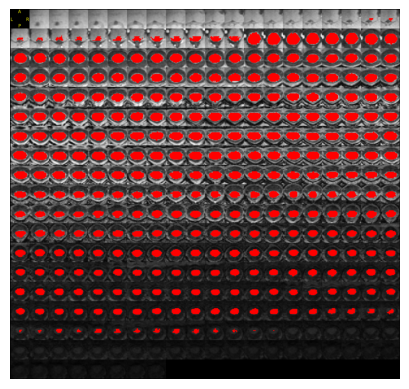

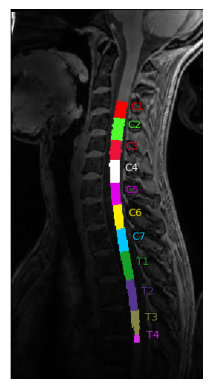

In [158]:
# Step 6: QC visualisation step
QA_image_path_deepseg=QA_image_path=os.path.join(QCfilepath,MP2RAGE_PROCESSING_PATH.split('/')[-3],
                                         MP2RAGE_PROCESSING_PATH.split('/')[-2],
                                         MP2RAGE_PROCESSING_PATH.split('/')[-1], 'sct_deepseg_sc')
QA_image_path_deepseg=os.path.join(QA_image_path_deepseg,sorted(os.listdir(QA_image_path_deepseg))[-1]) #necessary to ensure the latest result is shown
QA_image_background_deepseg=os.path.join(QA_image_path_deepseg,'bkg_img.png')
QA_image_foreground_deepseg=os.path.join(QA_image_path_deepseg,'overlay_img.png')

QA_image_path_label=os.path.join(QCfilepath,MP2RAGE_PROCESSING_PATH.split('/')[-3],
                                         MP2RAGE_PROCESSING_PATH.split('/')[-2],
                                         MP2RAGE_PROCESSING_PATH.split('/')[-1], 'sct_label_vertebrae')
QA_image_path_label=os.path.join(QA_image_path_label,sorted(os.listdir(QA_image_path_label))[-1]) #necessary to ensure the latest result is shown
QA_image_background_label=os.path.join(QA_image_path_label,'bkg_img.png')
QA_image_foreground_label=os.path.join(QA_image_path_label,'overlay_img.png')

image_paths_deepseg = [QA_image_background_deepseg,QA_image_foreground_deepseg]
# Open and load all the images
images = [Image.open(image_path) for image_path in image_paths_deepseg]
# Get the dimensions of the first image
width, height = images[0].size
# Create a new blank image to overlay onto
overlay_image = Image.new('RGBA', (width, height), (0, 0, 0, 0))
# Overlay each image onto the blank image
for image in images:
    overlay_image = Image.alpha_composite(overlay_image, image.convert('RGBA'))
# Convert the PIL image to a NumPy array
overlay_array = np.array(overlay_image)
# Display the overlaid image using matplotlib
plt.imshow(overlay_array)
plt.axis('off')  # Turn off axis labels and ticks
plt.show()

image_paths_label = [QA_image_background_label,QA_image_foreground_label]
# Open and load all the images
images = [Image.open(image_path) for image_path in image_paths_label]
# Get the dimensions of the first image
width, height = images[0].size
# Create a new blank image to overlay onto
overlay_image = Image.new('RGBA', (width, height), (0, 0, 0, 0))
# Overlay each image onto the blank image
for image in images:
    overlay_image = Image.alpha_composite(overlay_image, image.convert('RGBA'))
# Convert the PIL image to a NumPy array
overlay_array = np.array(overlay_image)
# Display the overlaid image using matplotlib
plt.imshow(overlay_array)
plt.axis('off')  # Turn off axis labels and ticks
plt.show()

# TFL_B1map processing

## Here, the following steps are carried out:

## First, the anatomical and B1+ maps of the TFL_B1map scan acquired with Optimal Reference Voltage are identified

## Second, the anatomical is coregistered to the MP2RAGE scan, and the mask derived from the MP2RAGE scan is warped to the space of the B1+ map

## Third, the B1+ map is rescaled into nT/V

## Fourth, the warped mask if used to extract the B1+ efficiency along the spinal cord


In [159]:
# Step 1: Setting all the user-defined variables

Target_FA=90 # change this to 80 for MAGNETOM scans!
#root_dir='/Users/danielpapp/DATA/Traveling_Spines'
#site_name='MGH'
#subject_name='SubD'
scan_name_TFL_B1_C3C4='TFL_B1_C3C4'

In [160]:
# Step 2: select the anatmical and B1+ map

TFL_C3C4_PATH = find_scan_dir(root_dir,site_name,subject_name,scan_name_TFL_B1_C3C4)
TFL_C3C4_anatfile = find_matching_nii_json_pairs(TFL_C3C4_PATH, 'anatomical', 'ImageComments')[0]
TFL_C3C4_B1mapfile = find_matching_nii_json_pairs(TFL_C3C4_PATH, 'angle map', 'ImageComments')[0]


In [161]:
# Step 3: Predefine filenames and paths for PROCESSING
TFL_B1_C3C4_PROCESSING_PATH=os.path.join(root_dir,'Processing',site_name,subject_name,scan_name_TFL_B1_C3C4)
if not os.path.isdir(TFL_B1_C3C4_PROCESSING_PATH):
    os.makedirs(TFL_B1_C3C4_PROCESSING_PATH)

QCfilepath=os.path.join(TFL_B1_C3C4_PROCESSING_PATH,'qc')
TFL_B1_C3C4_warp_2_MP2RAGEfilename=os.path.join(TFL_B1_C3C4_PROCESSING_PATH,TFL_C3C4_anatfile.split('.')[0].split('/')[-1]+'_warp_2_MP2RAGE.nii.gz')
warpMP2RAGE_2_TFLB1filename=os.path.join(TFL_B1_C3C4_PROCESSING_PATH,TFL_C3C4_anatfile.split('.')[0].split('/')[-1]+'_warp_MP2RAGE_2_B1.nii.gz')
warpedmaskname=os.path.join(TFL_B1_C3C4_PROCESSING_PATH,TFL_C3C4_anatfile.split('.')[0].split('/')[-1]+'_MP2RAGE_mask_warped.nii.gz')
TFL_C3C4_B1mapfile_nTpV=os.path.join(TFL_B1_C3C4_PROCESSING_PATH,TFL_C3C4_B1mapfile.split('.')[0].split('/')[-1]+'_nTpV.nii.gz')
TFL_C3C4_B1mapfile_CSV=os.path.join(TFL_B1_C3C4_PROCESSING_PATH,TFL_C3C4_B1mapfile.split('.')[0].split('/')[-1]+'_nTpV.csv')

In [162]:
print(TFL_B1_C3C4_warp_2_MP2RAGEfilename)
print(warpMP2RAGE_2_TFLB1filename)

/content/Traveling_Spines_7T/Processing/MNI/SubL/TFL_B1_C3C4/7_tfl_sag_2p5mmISO_largeFOV_RefVolOpt_warp_2_MP2RAGE.nii.gz
/content/Traveling_Spines_7T/Processing/MNI/SubL/TFL_B1_C3C4/7_tfl_sag_2p5mmISO_largeFOV_RefVolOpt_warp_MP2RAGE_2_B1.nii.gz


In [163]:
# Step 4: Coregistering the anatomical of the B1 scan to the MP2RAGE scan and warping the mask

# First, lets make sure that the results from the MP2RAGE processing exist
[MP2RAGE_UNI_filename,MP2RAGE_UNI_maskfilename]=MP2RAGE_checker(root_dir,site_name,subject_name,scan_name_TFL_B1_C3C4)

# Then, lets coregister the scans
#run_subprocess(f"sct_register_multimodal -i {TFL_C3C4_anatfile} -d {MP2RAGE_UNI_filename} -ofolder {TFL_B1_C3C4_PROCESSING_PATH} -owarp {TFL_B1_C3C4_warp_2_MP2RAGEfilename} -owarpinv {warpMP2RAGE_2_TFLB1filename} -qc {QCfilepath}")
run_subprocess(f"sct_register_multimodal -d {TFL_C3C4_anatfile} -i {MP2RAGE_UNI_filename} -ofolder {TFL_B1_C3C4_PROCESSING_PATH} -owarp {warpMP2RAGE_2_TFLB1filename} -qc {QCfilepath}")

# Apply the warp to the mask
run_subprocess(f"sct_apply_transfo -i {MP2RAGE_UNI_maskfilename} -d {TFL_C3C4_anatfile} -w {warpMP2RAGE_2_TFLB1filename} -o {warpedmaskname} -x nn")

In [164]:
# Step 5: Converting the B1+ map for flip angle to nT/V and then extracting the value along the spinal cord

# finding the reference voltage
TFL_B1_C3C4_jsonfile = TFL_C3C4_B1mapfile.replace(".nii.gz", ".json")
RefVol_C3C4 = extract_tx_ref_amp(TFL_B1_C3C4_jsonfile)

# Maths for Kyle Gilbert
#GAMMA = 2.675e8
#VoltageAtSocket = RefVol_C3C4 * 10**-0.095
#B1eff_mag = (AcquiredFA ./ RequestedFA) .* (pi ./ (GAMMA .* 1e-3 .* VoltageAtSocket)); % [T/V]
#B1eff_mag = B1eff_mag .* 1e9; % [T/V] to [nT/V]
# The costants sum up to 130.492, so to convert the B1map to nT/V, it has to be divided by 10 (to get it back into units of FA)
# then multiplied by 130.492 and divided by the VoltageAtSocket
VoltageAtSocket = RefVol_C3C4 * 10**-0.095

# sct_maths did something funky with one of the divisions, switching to niimath for now
run_subprocess(f"niimath {TFL_C3C4_B1mapfile} -div 10 -mul 130.492 -div {VoltageAtSocket} {TFL_C3C4_B1mapfile_nTpV}")

# Finally, we can use the warped mask to extract the B1+ efficiency along the SC
run_subprocess(f"sct_extract_metric -i {TFL_C3C4_B1mapfile_nTpV} -f {warpedmaskname} -perslice 1 -o {TFL_C3C4_B1mapfile_CSV}")

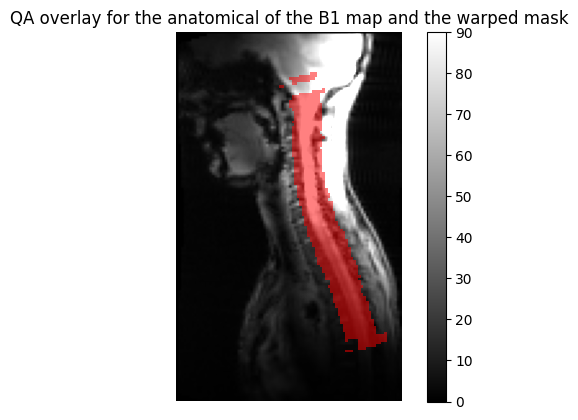

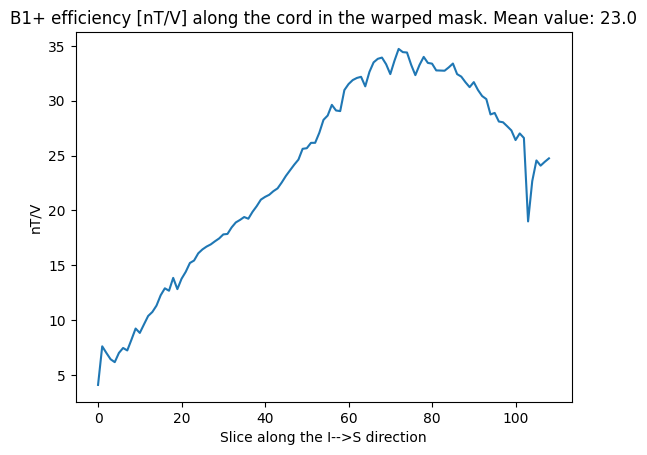

In [165]:
# Step 6: Visual QA for the coregisration of the mask and plotting the B1+ efficiency
# Shamelssly stolen from
# https://colab.research.google.com/github/evaalonsoortiz/7t-spine-coil/blob/main/7t_spine_coil_demo.ipynb

tfl_b1_anat = nib.load(TFL_C3C4_anatfile)
warped_mask = nib.load(warpedmaskname)
img_data = tfl_b1_anat.get_fdata()
seg_data = warped_mask.get_fdata()
seg_data = np.ma.masked_where(seg_data < 0.3, seg_data)

# Overlay the two images
fig, ax = plt.subplots()
plt.axis('off')
img1 = ax.imshow(np.rot90(img_data[:,:,28]/10), cmap=plt.cm.gray)
ax.imshow(np.rot90(seg_data[:,:,28]), cmap=plt.cm.autumn, interpolation='none', alpha=0.5)
plt.colorbar(img1)
img1.set_clim(vmin=0, vmax=90)
plt.title('QA overlay for the anatomical of the B1 map and the warped mask')
plt.show()

TFL_B1_nTpV_along_cord=signal_extractor_from_csv(TFL_C3C4_B1mapfile_CSV)
TFL_B1_nTpV_along_cord = TFL_B1_nTpV_along_cord[~np.isnan(TFL_B1_nTpV_along_cord)] #remove NANs
plt.plot(TFL_B1_nTpV_along_cord)
TFL_B1_nTpV_along_cord_mean=np.round(np.mean(TFL_B1_nTpV_along_cord))
titlestring= f"B1+ efficiency [nT/V] along the cord in the warped mask. Mean value: {TFL_B1_nTpV_along_cord_mean}"
plt.title(titlestring)
plt.xlabel('Slice along the I-->S direction')
plt.ylabel('nT/V')
plt.show()

# DREAM_B1map processing: LARGE FOV

## Here, the following steps are carried out:

## First, the anatomical and B1+ maps of the LARGE FOV DREAM scan acquired with Optimal Reference Voltage are identified

## Second, the anatomical is coregistered to the MP2RAGE scan, and the mask derived from the MP2RAGE scan is warped to the space of the B1+ map

## Third, the B1+ map is rescaled into nT/V

## Fourth, the warped mask if used to extract the B1+ efficiency along the spinal cord


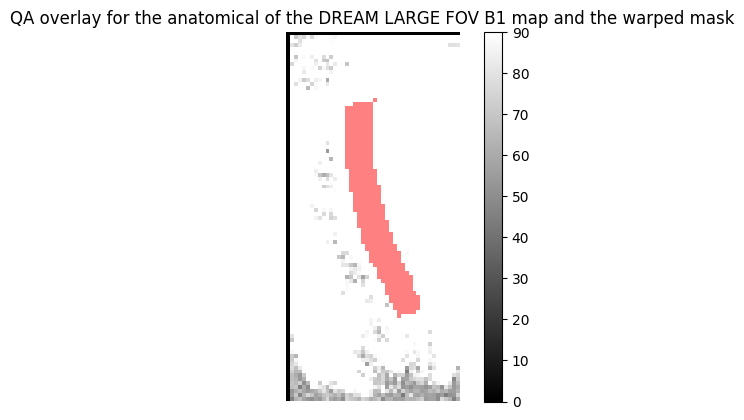

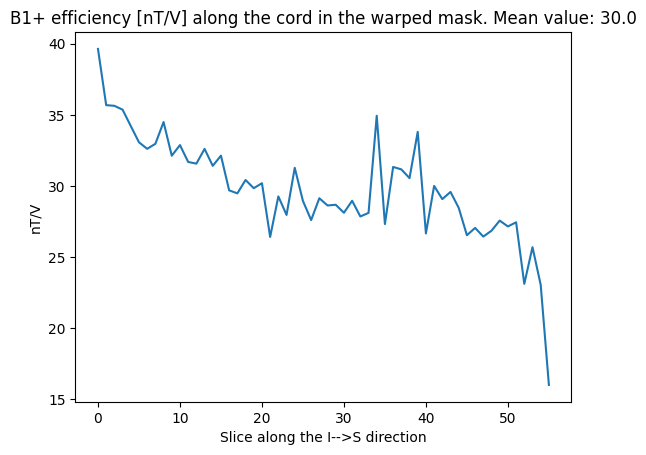

In [140]:
# Step 1: Setting all the user-defined variables
#root_dir='/Users/danielpapp/DATA/Traveling_Spines'
#site_name='MGH'
#subject_name='SubD'
scan_name_DREAM_LARGE='DREAM_LARGE'


# Step 2: select the anatmical and B1+ map
DREAM_LARGE_PATH = find_scan_dir(root_dir,site_name,subject_name,scan_name_DREAM_LARGE)
DREAM_LARGE_anatfile = find_matching_nii_json_pairs(DREAM_LARGE_PATH, 'FID', 'ImageComments')[-1] #this will be the distortion corrrected anatomical
DREAM_LARGE_B1mapfile = find_matching_nii_json_pairs(DREAM_LARGE_PATH, 'Flipangle Map', 'ImageComments')[-1] # this will be the distortion corrected map


# Step 3: Predefine filenames and paths for PROCESSING
DREAM_LARGE_PROCESSING_PATH=os.path.join(root_dir,'Processing',site_name,subject_name,scan_name_DREAM_LARGE)
if not os.path.isdir(DREAM_LARGE_PROCESSING_PATH):
    os.makedirs(DREAM_LARGE_PROCESSING_PATH)

QCfilepath_DREAM_LARGE=os.path.join(DREAM_LARGE_PROCESSING_PATH,'qc')
DREAM_LARGE_warp_2_MP2RAGEfilename=os.path.join(DREAM_LARGE_PROCESSING_PATH,DREAM_LARGE_anatfile.split('.')[0].split('/')[-1]+'_warp_2_MP2RAGE.nii.gz')
warpMP2RAGE_2_DREAM_LARGEfilename=os.path.join(DREAM_LARGE_PROCESSING_PATH,DREAM_LARGE_anatfile.split('.')[0].split('/')[-1]+'_warp_MP2RAGE_2_DREAM.nii.gz')
warpedmaskname_DREAM_LARGE=os.path.join(DREAM_LARGE_PROCESSING_PATH,DREAM_LARGE_anatfile.split('.')[0].split('/')[-1]+'_MP2RAGE_mask_warped.nii.gz')
DREAM_LARGE_B1mapfile_nTpV=os.path.join(DREAM_LARGE_PROCESSING_PATH,DREAM_LARGE_anatfile.split('.')[0].split('/')[-1]+'_nTpV.nii.gz')
DREAM_LARGE_B1mapfile_CVS=os.path.join(DREAM_LARGE_PROCESSING_PATH,DREAM_LARGE_anatfile.split('.')[0].split('/')[-1]+'_nTpV.csv')

# Step 4: Coregistering the anatomical of the B1 scan to the MP2RAGE scan and warping the mask

# First, lets make sure that the results from the MP2RAGE processing exist
[MP2RAGE_UNI_filename,MP2RAGE_UNI_maskfilename]=MP2RAGE_checker(root_dir,site_name,subject_name,scan_name_DREAM_LARGE)

# Then, lets coregister the scans
#run_subprocess(f"sct_register_multimodal -i {DREAM_LARGE_anatfile} -d {MP2RAGE_UNI_filename} -ofolder {DREAM_LARGE_PROCESSING_PATH} -owarp {DREAM_LARGE_warp_2_MP2RAGEfilename} -owarpinv {warpMP2RAGE_2_DREAM_LARGEfilename} -qc {QCfilepath_DREAM_LARGE}")
run_subprocess(f"sct_register_multimodal -d {DREAM_LARGE_anatfile} -i {MP2RAGE_UNI_filename} -ofolder {DREAM_LARGE_PROCESSING_PATH} -owarp {warpMP2RAGE_2_DREAM_LARGEfilename} -qc {QCfilepath_DREAM_LARGE}")

# Apply the warp to the mask
run_subprocess(f"sct_apply_transfo -i {MP2RAGE_UNI_maskfilename} -d {DREAM_LARGE_anatfile} -w {warpMP2RAGE_2_DREAM_LARGEfilename} -o {warpedmaskname_DREAM_LARGE} -x nn")

# Step 5: Converting the B1+ map for flip angle to nT/V and then extracting the value along the spinal cord

# finding the reference voltage
DREAM_LARGE_jsonfile = DREAM_LARGE_B1mapfile.replace(".nii.gz", ".json")
RefVol_DREAM_LARGE = extract_tx_ref_amp(DREAM_LARGE_jsonfile)
# We also need the flip angle here, as this might have been modified by users
FA_DREAM_LARGE = extract_FA(DREAM_LARGE_jsonfile)

# Maths for Kyle Gilbert
GAMMA = 2.675e8
VoltageAtSocket = RefVol_DREAM_LARGE * 10**-0.095
B1_nTpV_multiplier_DREAM_LARGE = (1 / FA_DREAM_LARGE) * (np.pi*1e9 / (GAMMA * 1e-3 * VoltageAtSocket)) /10
run_subprocess(f"niimath {DREAM_LARGE_B1mapfile} -mul {B1_nTpV_multiplier_DREAM_LARGE} {DREAM_LARGE_B1mapfile_nTpV}")

# Finally, we can use the warped mask to extract the B1+ efficiency along the SC
run_subprocess(f"sct_extract_metric -i {DREAM_LARGE_B1mapfile_nTpV} -f {warpedmaskname_DREAM_LARGE} -perslice 1 -o {DREAM_LARGE_B1mapfile_CVS}")

# Step 6: Visual QA for the coregisration of the mask and plotting the B1+ efficiency
# Shamelssly stolen from
# https://colab.research.google.com/github/evaalonsoortiz/7t-spine-coil/blob/main/7t_spine_coil_demo.ipynb

DREAM_LARGE_anat = nib.load(DREAM_LARGE_anatfile)
warped_mask_DREAM_LARGE = nib.load(warpedmaskname_DREAM_LARGE)
img_data = DREAM_LARGE_anat.get_fdata()
seg_data = warped_mask_DREAM_LARGE.get_fdata()
seg_data = np.ma.masked_where(seg_data < 0.3, seg_data)

# Overlay the two images
fig, ax = plt.subplots()
plt.axis('off')

img1 = ax.imshow(np.rot90(img_data[:,:,int(np.round(img_data.shape[-1]/2))]/10), cmap=plt.cm.gray)
ax.imshow(np.rot90(seg_data[:,:,int(np.round(img_data.shape[-1]/2))]), cmap=plt.cm.autumn, interpolation='none', alpha=0.5)
plt.colorbar(img1)
img1.set_clim(vmin=0, vmax=90)
plt.title('QA overlay for the anatomical of the DREAM LARGE FOV B1 map and the warped mask')
plt.show()

DREAM_LARGE_nTpV_along_cord=signal_extractor_from_csv(DREAM_LARGE_B1mapfile_CVS)
DREAM_LARGE_nTpV_along_cord = DREAM_LARGE_nTpV_along_cord[~np.isnan(DREAM_LARGE_nTpV_along_cord)] #remove NANs
plt.plot(DREAM_LARGE_nTpV_along_cord)
DREAM_LARGE_nTpV_along_cord_mean=np.round(np.mean(DREAM_LARGE_nTpV_along_cord))
titlestring= f"B1+ efficiency [nT/V] along the cord in the warped mask. Mean value: {DREAM_LARGE_nTpV_along_cord_mean}"
plt.title(titlestring)
plt.xlabel('Slice along the I-->S direction')
plt.ylabel('nT/V')
plt.show()

# DREAM_B1map processing: MEDIUM FOV

## Here, the following steps are carried out:

## First, the anatomical and B1+ maps of the MEDIUM FOV DREAM scan acquired with Optimal Reference Voltage are identified

## Second, the anatomical is coregistered to the MP2RAGE scan, and the mask derived from the MP2RAGE scan is warped to the space of the B1+ map

## Third, the B1+ map is rescaled into nT/V

## Fourth, the warped mask if used to extract the B1+ efficiency along the spinal cord

## Fifth, this process is repeated for the Medium FOV DREAM scans acquired with 2/3rd and 150% of the Optimal Reference Voltage (or 2/3rds and hardware maximum, whichever is available)

### Optimal Reference Voltage MEDIUM FOV DREAM

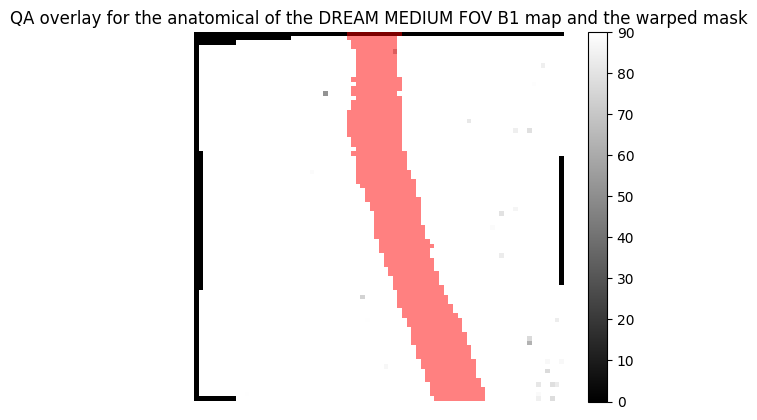

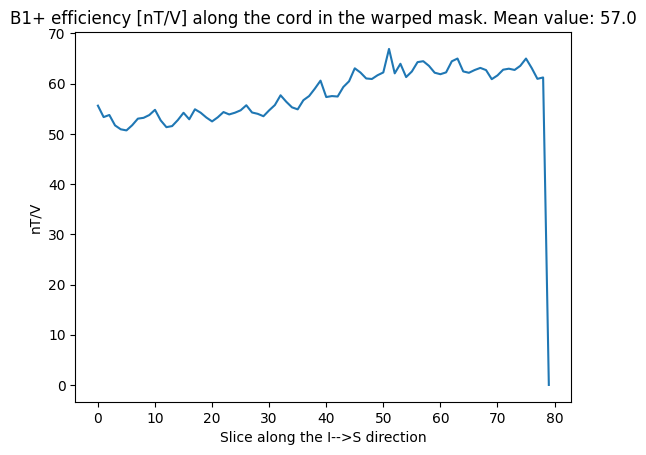

In [106]:
## Optimal Reference Voltage DREAM
# Step 1: Setting all the user-defined variables
#root_dir='/Users/danielpapp/DATA/Traveling_Spines'
#site_name='MGH'
#subject_name='SubD'
scan_name_DREAM_MEDIUM='DREAM_MEDIUM'

# Step 2: select the anatmical and B1+ map
DREAM_MEDIUM_PATH = find_scan_dir(root_dir,site_name,subject_name,scan_name_DREAM_MEDIUM)
DREAM_MEDIUM_anatfile = find_matching_nii_json_pairs(DREAM_MEDIUM_PATH, 'FID', 'ImageComments')[-1] #this will be the distortion corrrected anatomical
DREAM_MEDIUM_B1mapfile = find_matching_nii_json_pairs(DREAM_MEDIUM_PATH, 'Flipangle Map', 'ImageComments')[-1] # this will be the distortion corrected map

# Step 3: Predefine filenames and paths for PROCESSING
DREAM_MEDIUM_PROCESSING_PATH=os.path.join(root_dir,'Processing',site_name,subject_name,scan_name_DREAM_MEDIUM)
if not os.path.isdir(DREAM_MEDIUM_PROCESSING_PATH):
    os.makedirs(DREAM_MEDIUM_PROCESSING_PATH)

QCfilepath_DREAM_MEDIUM=os.path.join(DREAM_MEDIUM_PROCESSING_PATH,'qc')
DREAM_MEDIUM_warp_2_MP2RAGEfilename=os.path.join(DREAM_MEDIUM_PROCESSING_PATH,DREAM_MEDIUM_anatfile.split('.')[0].split('/')[-1]+'_warp_2_MP2RAGE.nii.gz')
warpMP2RAGE_2_DREAM_MEDIUMfilename=os.path.join(DREAM_MEDIUM_PROCESSING_PATH,DREAM_MEDIUM_anatfile.split('.')[0].split('/')[-1]+'_warp_MP2RAGE_2_DREAM.nii.gz')
warpedmaskname_DREAM_MEDIUM=os.path.join(DREAM_MEDIUM_PROCESSING_PATH,DREAM_MEDIUM_anatfile.split('.')[0].split('/')[-1]+'_MP2RAGE_mask_warped.nii.gz')
DREAM_MEDIUM_B1mapfile_nTpV=os.path.join(DREAM_MEDIUM_PROCESSING_PATH,DREAM_MEDIUM_anatfile.split('.')[0].split('/')[-1]+'_nTpV.nii.gz')
DREAM_MEDIUM_B1mapfile_CVS=os.path.join(DREAM_MEDIUM_PROCESSING_PATH,DREAM_MEDIUM_anatfile.split('.')[0].split('/')[-1]+'_nTpV.csv')

# Step 4: Coregistering the anatomical of the B1 scan to the MP2RAGE scan and warping the mask

# First, lets make sure that the results from the MP2RAGE processing exist
[MP2RAGE_UNI_filename,MP2RAGE_UNI_maskfilename]=MP2RAGE_checker(root_dir,site_name,subject_name,scan_name_DREAM_MEDIUM)

# Then, lets coregister the scans
#run_subprocess(f"sct_register_multimodal -i {DREAM_MEDIUM_anatfile} -d {MP2RAGE_UNI_filename} -ofolder {DREAM_MEDIUM_PROCESSING_PATH} -owarp {DREAM_MEDIUM_warp_2_MP2RAGEfilename} -owarpinv {warpMP2RAGE_2_DREAM_MEDIUMfilename} -qc {QCfilepath_DREAM_MEDIUM}")
run_subprocess(f"sct_register_multimodal -d {DREAM_MEDIUM_anatfile} -i {MP2RAGE_UNI_filename} -ofolder {DREAM_MEDIUM_PROCESSING_PATH} -owarp {warpMP2RAGE_2_DREAM_MEDIUMfilename} -qc {QCfilepath_DREAM_MEDIUM}")

# Apply the warp to the mask
run_subprocess(f"sct_apply_transfo -i {MP2RAGE_UNI_maskfilename} -d {DREAM_MEDIUM_anatfile} -w {warpMP2RAGE_2_DREAM_MEDIUMfilename} -o {warpedmaskname_DREAM_MEDIUM} -x nn")

# Step 5: Converting the B1+ map for flip angle to nT/V and then extracting the value along the spinal cord

# finding the reference voltage
DREAM_MEDIUM_jsonfile = DREAM_MEDIUM_B1mapfile.replace(".nii.gz", ".json")
RefVol_DREAM_MEDIUM = extract_tx_ref_amp(DREAM_MEDIUM_jsonfile)
# We also need the flip angle here, as this might have been modified by users
FA_DREAM_MEDIUM = extract_FA(DREAM_MEDIUM_jsonfile)

# Maths for Kyle Gilbert
GAMMA = 2.675e8
VoltageAtSocket = RefVol_DREAM_MEDIUM * 10**-0.095
B1_nTpV_multiplier_DREAM_MEDIUM = (1 / FA_DREAM_MEDIUM) * (np.pi*1e9 / (GAMMA * 1e-3 * VoltageAtSocket)) /10
run_subprocess(f"niimath {DREAM_MEDIUM_B1mapfile} -mul {B1_nTpV_multiplier_DREAM_MEDIUM} {DREAM_MEDIUM_B1mapfile_nTpV}")

# Finally, we can use the warped mask to extract the B1+ efficiency along the SC
run_subprocess(f"sct_extract_metric -i {DREAM_MEDIUM_B1mapfile_nTpV} -f {warpedmaskname_DREAM_MEDIUM} -perslice 1 -o {DREAM_MEDIUM_B1mapfile_CVS}")

# Step 6: Visual QA for the coregisration of the mask and plotting the B1+ efficiency
# Shamelssly stolen from
# https://colab.research.google.com/github/evaalonsoortiz/7t-spine-coil/blob/main/7t_spine_coil_demo.ipynb

DREAM_MEDIUM_anat = nib.load(DREAM_MEDIUM_anatfile)
warped_mask_DREAM_MEDIUM = nib.load(warpedmaskname_DREAM_MEDIUM)
img_data = DREAM_MEDIUM_anat.get_fdata()
seg_data = warped_mask_DREAM_MEDIUM.get_fdata()
seg_data = np.ma.masked_where(seg_data < 0.3, seg_data)

# Overlay the two images
fig, ax = plt.subplots()
plt.axis('off')

img1 = ax.imshow(np.rot90(img_data[:,:,int(np.round(img_data.shape[-1]/2))]/10), cmap=plt.cm.gray)
ax.imshow(np.rot90(seg_data[:,:,int(np.round(img_data.shape[-1]/2))]), cmap=plt.cm.autumn, interpolation='none', alpha=0.5)
plt.colorbar(img1)
img1.set_clim(vmin=0, vmax=90)
plt.title('QA overlay for the anatomical of the DREAM MEDIUM FOV B1 map and the warped mask')
plt.show()

DREAM_MEDIUM_nTpV_along_cord=signal_extractor_from_csv(DREAM_MEDIUM_B1mapfile_CVS)
DREAM_MEDIUM_nTpV_along_cord = DREAM_MEDIUM_nTpV_along_cord[~np.isnan(DREAM_MEDIUM_nTpV_along_cord)] #remove NANs
plt.plot(DREAM_MEDIUM_nTpV_along_cord)
DREAM_MEDIUM_nTpV_along_cord_mean=np.round(np.mean(DREAM_MEDIUM_nTpV_along_cord))
titlestring= f"B1+ efficiency [nT/V] along the cord in the warped mask. Mean value: {DREAM_MEDIUM_nTpV_along_cord_mean}"
plt.title(titlestring)
plt.xlabel('Slice along the I-->S direction')
plt.ylabel('nT/V')
plt.show()

### 2/3rds of Optimal Reference Voltage MEDIUM FOV DREAM

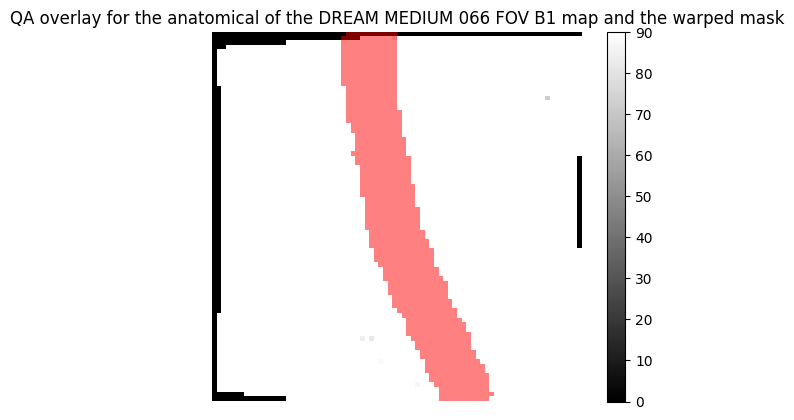

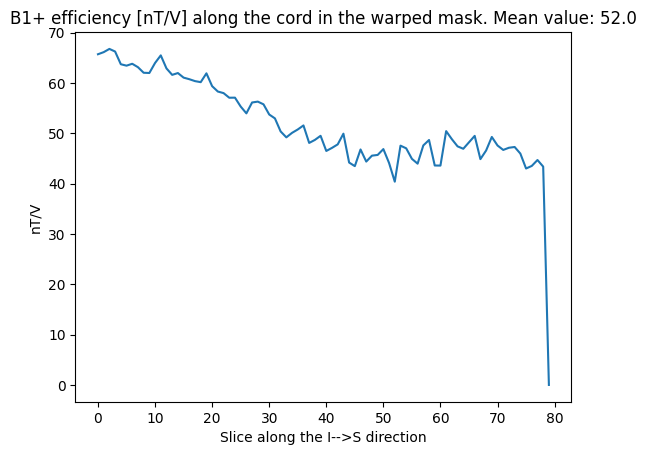

In [142]:
## 2/3rds of Optimal Reference Voltage DREAM
# Step 1: Setting all the user-defined variables
#root_dir='/Users/danielpapp/DATA/Traveling_Spines'
#site_name='MGH'
#subject_name='SubD'
scan_name_DREAM_MEDIUM_066='DREAM_MEDIUM_066'

# Step 2: select the anatmical and B1+ map
DREAM_MEDIUM_PATH_066 = find_scan_dir(root_dir,site_name,subject_name,scan_name_DREAM_MEDIUM_066)
DREAM_MEDIUM_anatfile_066 = find_matching_nii_json_pairs(DREAM_MEDIUM_PATH_066, 'FID', 'ImageComments')[-1] #this will be the distortion corrrected anatomical
DREAM_MEDIUM_B1mapfile_066 = find_matching_nii_json_pairs(DREAM_MEDIUM_PATH_066, 'Flipangle Map', 'ImageComments')[-1] # this will be the distortion corrected map

# Step 3: Predefine filenames and paths for PROCESSING
DREAM_MEDIUM_PROCESSING_PATH_066=os.path.join(root_dir,'Processing',site_name,subject_name,scan_name_DREAM_MEDIUM_066)
if not os.path.isdir(DREAM_MEDIUM_PROCESSING_PATH_066):
    os.makedirs(DREAM_MEDIUM_PROCESSING_PATH_066)

QCfilepath_DREAM_MEDIUM_066=os.path.join(DREAM_MEDIUM_PROCESSING_PATH_066,'qc')
DREAM_MEDIUM_warp_2_MP2RAGEfilename_066=os.path.join(DREAM_MEDIUM_PROCESSING_PATH_066,DREAM_MEDIUM_anatfile_066.split('.')[0].split('/')[-1]+'_warp_2_MP2RAGE.nii.gz')
warpMP2RAGE_2_DREAM_MEDIUMfilename_066=os.path.join(DREAM_MEDIUM_PROCESSING_PATH_066,DREAM_MEDIUM_anatfile_066.split('.')[0].split('/')[-1]+'_warp_MP2RAGE_2_DREAM.nii.gz')
warpedmaskname_DREAM_MEDIUM_066=os.path.join(DREAM_MEDIUM_PROCESSING_PATH_066,DREAM_MEDIUM_anatfile_066.split('.')[0].split('/')[-1]+'_MP2RAGE_mask_warped.nii.gz')
DREAM_MEDIUM_B1mapfile_nTpV_066=os.path.join(DREAM_MEDIUM_PROCESSING_PATH_066,DREAM_MEDIUM_anatfile_066.split('.')[0].split('/')[-1]+'_nTpV.nii.gz')
DREAM_MEDIUM_B1mapfile_CVS_066=os.path.join(DREAM_MEDIUM_PROCESSING_PATH_066,DREAM_MEDIUM_anatfile_066.split('.')[0].split('/')[-1]+'_nTpV.csv')

# Step 4: Coregistering the anatomical of the B1 scan to the MP2RAGE scan and warping the mask

# First, lets make sure that the results from the MP2RAGE processing exist
[MP2RAGE_UNI_filename,MP2RAGE_UNI_maskfilename]=MP2RAGE_checker(root_dir,site_name,subject_name,scan_name_DREAM_MEDIUM_066)

# Then, lets coregister the scans
#run_subprocess(f"sct_register_multimodal -i {DREAM_MEDIUM_anatfile_066} -d {MP2RAGE_UNI_filename} -ofolder {DREAM_MEDIUM_PROCESSING_PATH_066} -owarp {DREAM_MEDIUM_warp_2_MP2RAGEfilename_066} -owarpinv {warpMP2RAGE_2_DREAM_MEDIUMfilename_066} -qc {QCfilepath_DREAM_MEDIUM_066}")
run_subprocess(f"sct_register_multimodal -d {DREAM_MEDIUM_anatfile_066} -i {MP2RAGE_UNI_filename} -ofolder {DREAM_MEDIUM_PROCESSING_PATH_066} -owarp {warpMP2RAGE_2_DREAM_MEDIUMfilename_066} -qc {QCfilepath_DREAM_MEDIUM_066}")

# Apply the warp to the mask
run_subprocess(f"sct_apply_transfo -i {MP2RAGE_UNI_maskfilename} -d {DREAM_MEDIUM_anatfile_066} -w {warpMP2RAGE_2_DREAM_MEDIUMfilename_066} -o {warpedmaskname_DREAM_MEDIUM_066} -x nn")

# Step 5: Converting the B1+ map for flip angle to nT/V and then extracting the value along the spinal cord

# finding the reference voltage
DREAM_MEDIUM_jsonfile_066 = DREAM_MEDIUM_B1mapfile_066.replace(".nii.gz", ".json")
RefVol_DREAM_MEDIUM_066 = extract_tx_ref_amp(DREAM_MEDIUM_jsonfile_066)
# We also need the flip angle here, as this might have been modified by users
FA_DREAM_MEDIUM_066 = extract_FA(DREAM_MEDIUM_jsonfile_066)

# Maths for Kyle Gilbert
GAMMA = 2.675e8
VoltageAtSocket_066 = RefVol_DREAM_MEDIUM_066 * 10**-0.095
B1_nTpV_multiplier_DREAM_MEDIUM_066 = (1 / FA_DREAM_MEDIUM_066) * (np.pi*1e9 / (GAMMA * 1e-3 * VoltageAtSocket_066)) /10
run_subprocess(f"niimath {DREAM_MEDIUM_B1mapfile_066} -mul {B1_nTpV_multiplier_DREAM_MEDIUM_066} {DREAM_MEDIUM_B1mapfile_nTpV_066}")

# Finally, we can use the warped mask to extract the B1+ efficiency along the SC
run_subprocess(f"sct_extract_metric -i {DREAM_MEDIUM_B1mapfile_nTpV_066} -f {warpedmaskname_DREAM_MEDIUM_066} -perslice 1 -o {DREAM_MEDIUM_B1mapfile_CVS_066}")

# Step 6: Visual QA for the coregisration of the mask and plotting the B1+ efficiency
# Shamelssly stolen from
# https://colab.research.google.com/github/evaalonsoortiz/7t-spine-coil/blob/main/7t_spine_coil_demo.ipynb

DREAM_MEDIUM_anat_066 = nib.load(DREAM_MEDIUM_anatfile_066)
warped_mask_DREAM_MEDIUM_066 = nib.load(warpedmaskname_DREAM_MEDIUM_066)
img_data = DREAM_MEDIUM_anat_066.get_fdata()
seg_data = warped_mask_DREAM_MEDIUM_066.get_fdata()
seg_data = np.ma.masked_where(seg_data < 0.3, seg_data)

# Overlay the two images
fig, ax = plt.subplots()
plt.axis('off')

img1 = ax.imshow(np.rot90(img_data[:,:,int(np.round(img_data.shape[-1]/2))]/10), cmap=plt.cm.gray)
ax.imshow(np.rot90(seg_data[:,:,int(np.round(img_data.shape[-1]/2))]), cmap=plt.cm.autumn, interpolation='none', alpha=0.5)
plt.colorbar(img1)
img1.set_clim(vmin=0, vmax=90)
plt.title('QA overlay for the anatomical of the DREAM MEDIUM 066 FOV B1 map and the warped mask')
plt.show()

DREAM_MEDIUM_066_nTpV_along_cord=signal_extractor_from_csv(DREAM_MEDIUM_B1mapfile_CVS_066)
DREAM_MEDIUM_066_nTpV_along_cord = DREAM_MEDIUM_066_nTpV_along_cord[~np.isnan(DREAM_MEDIUM_066_nTpV_along_cord)] #remove NANs
plt.plot(DREAM_MEDIUM_066_nTpV_along_cord)
DREAM_MEDIUM_066_nTpV_along_cord_mean=np.round(np.mean(DREAM_MEDIUM_066_nTpV_along_cord))
titlestring= f"B1+ efficiency [nT/V] along the cord in the warped mask. Mean value: {DREAM_MEDIUM_066_nTpV_along_cord_mean}"
plt.title(titlestring)
plt.xlabel('Slice along the I-->S direction')
plt.ylabel('nT/V')
plt.show()


### 150% or Hardware Limit of Optimal Reference Voltage MEDIUM FOV DREAM

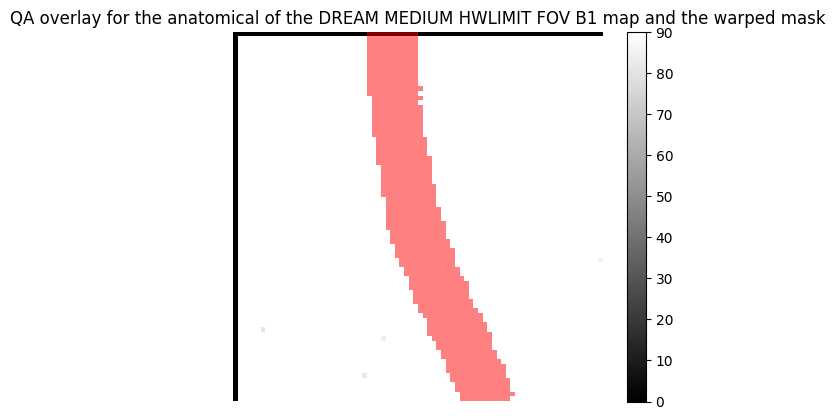

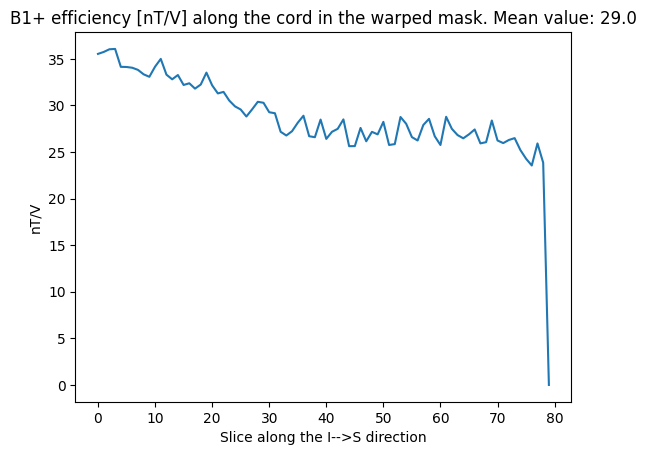

In [144]:
## 150% of Optimal Reference Voltage DREAM, or HW limit
# IT IS UP TO THE USER TO DEFINE IF IT IS A 150% SCAN OR A HW LIMIT SCAN!!!!!
# Step 1: Setting all the user-defined variables
#root_dir='/Users/danielpapp/DATA/Traveling_Spines'
#site_name='MGH'
#subject_name='SubD'
scan_name_DREAM_MEDIUM_HWLIMIT='DREAM_MEDIUM_HWLIMIT'

# Step 2: select the anatmical and B1+ map
DREAM_MEDIUM_PATH_HWLIMIT = find_scan_dir(root_dir,site_name,subject_name,scan_name_DREAM_MEDIUM_HWLIMIT)
DREAM_MEDIUM_anatfile_HWLIMIT = find_matching_nii_json_pairs(DREAM_MEDIUM_PATH_HWLIMIT, 'FID', 'ImageComments')[-1] #this will be the distortion corrrected anatomical
DREAM_MEDIUM_B1mapfile_HWLIMIT = find_matching_nii_json_pairs(DREAM_MEDIUM_PATH_HWLIMIT, 'Flipangle Map', 'ImageComments')[-1] # this will be the distortion corrected map

# Step 3: Predefine filenames and paths for PROCESSING
DREAM_MEDIUM_PROCESSING_PATH_HWLIMIT=os.path.join(root_dir,'Processing',site_name,subject_name,scan_name_DREAM_MEDIUM_HWLIMIT)
if not os.path.isdir(DREAM_MEDIUM_PROCESSING_PATH_HWLIMIT):
    os.makedirs(DREAM_MEDIUM_PROCESSING_PATH_HWLIMIT)

QCfilepath_DREAM_MEDIUM_HWLIMIT=os.path.join(DREAM_MEDIUM_PROCESSING_PATH_HWLIMIT,'qc')
DREAM_MEDIUM_warp_2_MP2RAGEfilename_HWLIMIT=os.path.join(DREAM_MEDIUM_PROCESSING_PATH_HWLIMIT,DREAM_MEDIUM_anatfile_HWLIMIT.split('.')[0].split('/')[-1]+'_warp_2_MP2RAGE.nii.gz')
warpMP2RAGE_2_DREAM_MEDIUMfilename_HWLIMIT=os.path.join(DREAM_MEDIUM_PROCESSING_PATH_HWLIMIT,DREAM_MEDIUM_anatfile_HWLIMIT.split('.')[0].split('/')[-1]+'_warp_MP2RAGE_2_DREAM.nii.gz')
warpedmaskname_DREAM_MEDIUM_HWLIMIT=os.path.join(DREAM_MEDIUM_PROCESSING_PATH_HWLIMIT,DREAM_MEDIUM_anatfile_HWLIMIT.split('.')[0].split('/')[-1]+'_MP2RAGE_mask_warped.nii.gz')
DREAM_MEDIUM_B1mapfile_nTpV_HWLIMIT=os.path.join(DREAM_MEDIUM_PROCESSING_PATH_HWLIMIT,DREAM_MEDIUM_anatfile_HWLIMIT.split('.')[0].split('/')[-1]+'_nTpV.nii.gz')
DREAM_MEDIUM_B1mapfile_CVS_HWLIMIT=os.path.join(DREAM_MEDIUM_PROCESSING_PATH_HWLIMIT,DREAM_MEDIUM_anatfile_HWLIMIT.split('.')[0].split('/')[-1]+'_nTpV.csv')

# Step 4: Coregistering the anatomical of the B1 scan to the MP2RAGE scan and warping the mask

# First, lets make sure that the results from the MP2RAGE processing exist
[MP2RAGE_UNI_filename,MP2RAGE_UNI_maskfilename]=MP2RAGE_checker(root_dir,site_name,subject_name,scan_name_DREAM_MEDIUM_HWLIMIT)

# Then, lets coregister the scans
#run_subprocess(f"sct_register_multimodal -i {DREAM_MEDIUM_anatfile_HWLIMIT} -d {MP2RAGE_UNI_filename} -ofolder {DREAM_MEDIUM_PROCESSING_PATH_HWLIMIT} -owarp {DREAM_MEDIUM_warp_2_MP2RAGEfilename_HWLIMIT} -owarpinv {warpMP2RAGE_2_DREAM_MEDIUMfilename_HWLIMIT} -qc {QCfilepath_DREAM_MEDIUM_HWLIMIT}")
run_subprocess(f"sct_register_multimodal -d {DREAM_MEDIUM_anatfile_HWLIMIT} -i {MP2RAGE_UNI_filename} -ofolder {DREAM_MEDIUM_PROCESSING_PATH_HWLIMIT} -owarp {warpMP2RAGE_2_DREAM_MEDIUMfilename_HWLIMIT} -qc {QCfilepath_DREAM_MEDIUM_HWLIMIT}")

# Apply the warp to the mask
run_subprocess(f"sct_apply_transfo -i {MP2RAGE_UNI_maskfilename} -d {DREAM_MEDIUM_anatfile_HWLIMIT} -w {warpMP2RAGE_2_DREAM_MEDIUMfilename_HWLIMIT} -o {warpedmaskname_DREAM_MEDIUM_HWLIMIT} -x nn")

# Step 5: Converting the B1+ map for flip angle to nT/V and then extracting the value along the spinal cord

# finding the reference voltage
DREAM_MEDIUM_jsonfile_HWLIMIT = DREAM_MEDIUM_B1mapfile_HWLIMIT.replace(".nii.gz", ".json")
RefVol_DREAM_MEDIUM_HWLIMIT = extract_tx_ref_amp(DREAM_MEDIUM_jsonfile_HWLIMIT)
# We also need the flip angle here, as this might have been modified by users
FA_DREAM_MEDIUM_HWLIMIT = extract_FA(DREAM_MEDIUM_jsonfile_HWLIMIT)

# Maths for Kyle Gilbert
GAMMA = 2.675e8
VoltageAtSocket_HWLIMIT = RefVol_DREAM_MEDIUM_HWLIMIT * 10**-0.095
B1_nTpV_multiplier_DREAM_MEDIUM_HWLIMIT = (1 / FA_DREAM_MEDIUM_HWLIMIT) * (np.pi*1e9 / (GAMMA * 1e-3 * VoltageAtSocket_HWLIMIT)) /10
run_subprocess(f"niimath {DREAM_MEDIUM_B1mapfile_HWLIMIT} -mul {B1_nTpV_multiplier_DREAM_MEDIUM_HWLIMIT} {DREAM_MEDIUM_B1mapfile_nTpV_HWLIMIT}")

# Finally, we can use the warped mask to extract the B1+ efficiency along the SC
run_subprocess(f"sct_extract_metric -i {DREAM_MEDIUM_B1mapfile_nTpV_HWLIMIT} -f {warpedmaskname_DREAM_MEDIUM_HWLIMIT} -perslice 1 -o {DREAM_MEDIUM_B1mapfile_CVS_HWLIMIT}")

# Step 6: Visual QA for the coregisration of the mask and plotting the B1+ efficiency
# Shamelssly stolen from
# https://colab.research.google.com/github/evaalonsoortiz/7t-spine-coil/blob/main/7t_spine_coil_demo.ipynb

DREAM_MEDIUM_anat_HWLIMIT = nib.load(DREAM_MEDIUM_anatfile_HWLIMIT)
warped_mask_DREAM_MEDIUM_HWLIMIT = nib.load(warpedmaskname_DREAM_MEDIUM_HWLIMIT)
img_data = DREAM_MEDIUM_anat_HWLIMIT.get_fdata()
seg_data = warped_mask_DREAM_MEDIUM_HWLIMIT.get_fdata()
seg_data = np.ma.masked_where(seg_data < 0.3, seg_data)

# Overlay the two images
fig, ax = plt.subplots()
plt.axis('off')

img1 = ax.imshow(np.rot90(img_data[:,:,int(np.round(img_data.shape[-1]/2))]/10), cmap=plt.cm.gray)
ax.imshow(np.rot90(seg_data[:,:,int(np.round(img_data.shape[-1]/2))]), cmap=plt.cm.autumn, interpolation='none', alpha=0.5)
plt.colorbar(img1)
img1.set_clim(vmin=0, vmax=90)
plt.title('QA overlay for the anatomical of the DREAM MEDIUM HWLIMIT FOV B1 map and the warped mask')
plt.show()

DREAM_MEDIUM_HWLIMIT_nTpV_along_cord=signal_extractor_from_csv(DREAM_MEDIUM_B1mapfile_CVS_HWLIMIT)
DREAM_MEDIUM_HWLIMIT_nTpV_along_cord = DREAM_MEDIUM_HWLIMIT_nTpV_along_cord[~np.isnan(DREAM_MEDIUM_HWLIMIT_nTpV_along_cord)] #remove NANs
plt.plot(DREAM_MEDIUM_HWLIMIT_nTpV_along_cord)
DREAM_MEDIUM_HWLIMIT_nTpV_along_cord_mean=np.round(np.mean(DREAM_MEDIUM_HWLIMIT_nTpV_along_cord))
titlestring= f"B1+ efficiency [nT/V] along the cord in the warped mask. Mean value: {DREAM_MEDIUM_HWLIMIT_nTpV_along_cord_mean}"
plt.title(titlestring)
plt.xlabel('Slice along the I-->S direction')
plt.ylabel('nT/V')
plt.show()


# GRE processing

## Here, we grab the individual coil images, and display them in a tiled layout

### It could be further adapted to show some kind of metric (CoV?) calculated in the spinal cord mask
### Or just showing the spinal cord mask with an almost transparent overlay/outline

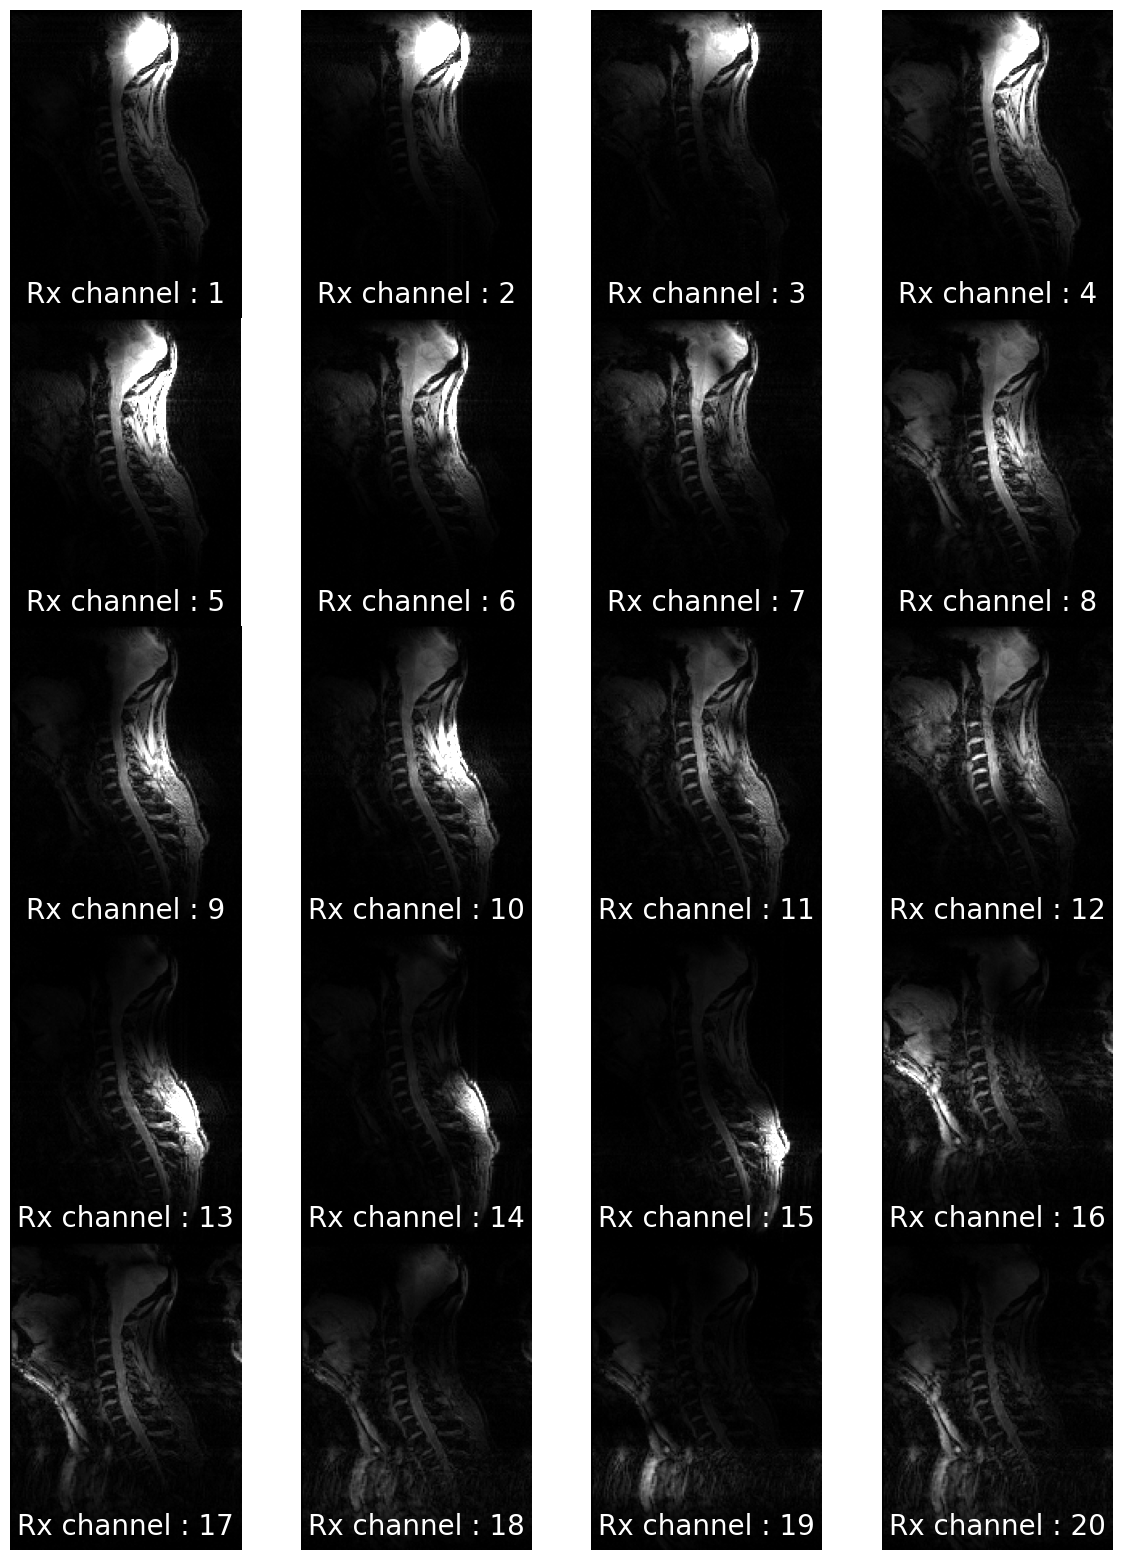

In [145]:
# GRE processing
### How many coil uncombined files are there?
# Step 1: Setting all the user-defined variables
#root_dir='/Users/danielpapp/DATA/Traveling_Spines'
#site_name='MGH'
#subject_name='SubD'
scan_name_GRE='GRE'

# Step 2: select individual coil images
GRE_PATH = find_scan_dir(root_dir,site_name,subject_name,scan_name_GRE)
all_gre_files=sorted(glob.glob(os.path.join(GRE_PATH, '*gre*uncomb*RX*.nii.gz')))
gre_phasefiles=sorted(glob.glob(os.path.join(GRE_PATH, '*gre*uncomb*RX*ph*.nii*')))
gre_magnitudes=sorted(list(set(all_gre_files)-set(gre_phasefiles)))

#Step 3: Tiled figure in a five-row layout
numberofgremagfiles=len(gre_magnitudes)
numberofrows=5
numberofcolumns=int(np.ceil(numberofgremagfiles/numberofrows))

fig=plt.figure(figsize=(15, 20))
ax = fig.subplots(numberofrows,numberofcolumns,squeeze=True)
for rowindex in range(numberofrows):
    for columnindex in range(numberofcolumns):
        indexoffigure=rowindex*numberofcolumns+columnindex
        #read in files
        data_to_plot=(nib.load(gre_magnitudes[indexoffigure])).get_fdata() #load in nifti object, get only image data
        data_to_plot=np.rot90(data_to_plot[:,:,int(np.ceil(data_to_plot.shape[2]/2))]) #central slice
        ax[rowindex,columnindex].imshow(data_to_plot,cmap=plt.cm.gray,clim=[0, 300])
        ax[rowindex,columnindex].text(0.5, 0.05, 'Rx channel : ' + str(indexoffigure+1),horizontalalignment='center', transform=ax[rowindex,columnindex].transAxes,color='white',fontsize=20)
        ax[rowindex,columnindex].axis('off')

plt.axis('off')
plt.subplots_adjust(hspace=0,wspace=0)
#fig.tight_layout()

# COILQA PROCESSING

## Here we do the following:

### First, we find the anatomical scan, the 1/g-factor map and the SNR map

### Second, we split the 1/g factor map into its 12 components, and we likewise split the SNR map

### Third, we crop the split maps using the anatomical (otherwise we would have to deal with 512x512 images)

### Forth, we visualize the 1/g factor map in a tiled layout, similar to the GRE scan

### Fifth, we coregister the CoilQA anatomical to the MP2RAGE scan, warp the mask to the CoilQA space, and extract the SNR along the spinal cord (Extracting does not work yet, because the cropping results in a 255x256 image insteead of a 256x256 one)

In [146]:
# Step 1: User defined paths and varaibles
#root_dir='/Users/danielpapp/DATA/Traveling_Spines'
#site_name='MGH'
#subject_name='SubD'
scan_name_COILQA_SAG_LARGE='COILQA_SAG_LARGE'

# Step 2: select the anatomical, SNR map and 1/g-factor maps
COILQA_SAG_LARGE_PATH = find_scan_dir(root_dir,site_name,subject_name,scan_name_COILQA_SAG_LARGE)
# Because there is no way to discriminate the anatomical based on JSON data (in brief, the anatomical is the only
# one that does NOT have an ImageComments field, but everything else is identical), we have to basically list
# all nifti files and remove the identified SNRmap, 1/g factor map and Noise Covariance matrix
COILQA_SAG_LARGE_GFACTOR = find_matching_nii_json_pairs(COILQA_SAG_LARGE_PATH, 'R=2', 'ImageComments')[-1]
COILQA_SAG_LARGE_SNRMAP = find_matching_nii_json_pairs(COILQA_SAG_LARGE_PATH, 'SNR', 'ImageComments')[-1]
COILQA_SAG_LARGE_COVARIANCE = find_matching_nii_json_pairs(COILQA_SAG_LARGE_PATH, 'mag', 'ImageComments')[-1]
all_nifties_in_dir=sorted(glob.glob(os.path.join(COILQA_SAG_LARGE_PATH, '*coilQA*.nii.gz')))
COILQA_SAG_LARGE_ANAT=sorted(list(set(all_nifties_in_dir)-set([COILQA_SAG_LARGE_GFACTOR,COILQA_SAG_LARGE_SNRMAP,COILQA_SAG_LARGE_COVARIANCE])))[-1]

# Step 3: Predefine filenames and paths for PROCESSING
COILQA_SAG_LARGE_PROCESSING_PATH=os.path.join(root_dir,'Processing',site_name,subject_name,scan_name_COILQA_SAG_LARGE)
if not os.path.isdir(COILQA_SAG_LARGE_PROCESSING_PATH):
    os.makedirs(COILQA_SAG_LARGE_PROCESSING_PATH)

QCfilepath_COILQA_SAG_LARGE=os.path.join(COILQA_SAG_LARGE_PROCESSING_PATH,'qc')
SNR_splitname=os.path.join(COILQA_SAG_LARGE_PROCESSING_PATH,COILQA_SAG_LARGE_SNRMAP.split('.')[0].split('/')[-1]+'_SNRsplit.nii.gz')
GFACTOR_splitname=os.path.join(COILQA_SAG_LARGE_PROCESSING_PATH,COILQA_SAG_LARGE_GFACTOR.split('.')[0].split('/')[-1]+'_Gfactorsplit.nii.gz')
COILQA_SAG_LARGE_warp_2_MP2RAGEfilename=os.path.join(COILQA_SAG_LARGE_PROCESSING_PATH,COILQA_SAG_LARGE_ANAT.split('.')[0].split('/')[-1]+'_warp_2_MP2RAGE.nii.gz')
warpMP2RAGE_2_COILQA_SAG_LARGEfilename=os.path.join(COILQA_SAG_LARGE_PROCESSING_PATH,COILQA_SAG_LARGE_ANAT.split('.')[0].split('/')[-1]+'_warp_MP2RAGE_2_COILQA_LARGE_SAG.nii.gz')
warpedmaskname_COILQA_SAG_LARGE=os.path.join(COILQA_SAG_LARGE_PROCESSING_PATH,COILQA_SAG_LARGE_ANAT.split('.')[0].split('/')[-1]+'_MP2RAGE_mask_warped.nii.gz')
COILQA_SAG_LARGE_SNR_OPT_CSV=os.path.join(COILQA_SAG_LARGE_PROCESSING_PATH,COILQA_SAG_LARGE_ANAT.split('.')[0].split('/')[-1]+'_SNR_Opt.csv')
COILQA_SAG_LARGE_SNR_RSS_CSV=os.path.join(COILQA_SAG_LARGE_PROCESSING_PATH,COILQA_SAG_LARGE_ANAT.split('.')[0].split('/')[-1]+'_SNR_RSS.csv')
#DREAM_MEDIUM_B1mapfile_CVS_HWLIMIT=os.path.join(DREAM_MEDIUM_PROCESSING_PATH_HWLIMIT,DREAM_MEDIUM_anatfile_HWLIMIT.split('.')[0].split('/')[-1]+'_nTpV.csv')


In [147]:
# Step 4: Splitting and cropping SNR map
# Removing exsisting files for cleanup (otherwise we end up with _cropped_cropped_cropped...)
SNRmap_splitnames=(SNR_splitname.split('/')[-1]).split('.')[0]+'*T*'
SNRmap_splitfiles=sorted(glob.glob(os.path.join(COILQA_SAG_LARGE_PROCESSING_PATH,SNRmap_splitnames)))
if (SNRmap_splitfiles):
  print('Removing exsisting split files for safety')
  for index in range(len(SNRmap_splitfiles)):
    os.remove(SNRmap_splitfiles[index])
# Splitting
run_subprocess(f"sct_image -i {COILQA_SAG_LARGE_SNRMAP} -split t -o {SNR_splitname}")
SNRmap_splitfiles=sorted(glob.glob(os.path.join(COILQA_SAG_LARGE_PROCESSING_PATH,SNRmap_splitnames)))
# Cropping
SNRmap_split_cropped_name=[None]*len(SNRmap_splitfiles)
for index in range(len(SNRmap_splitfiles)):
    SNRmap_split_cropped_name[index]=(SNRmap_splitfiles[index]).split('.')[0]+'_cropped.nii.gz'
    run_subprocess(f"sct_register_multimodal -i {SNRmap_splitfiles[index]} -d {COILQA_SAG_LARGE_ANAT} -o {SNRmap_split_cropped_name[index]} -identity 1")

# Step 5: Splitting and cropping 1/g factor map
# Removing exsisting files for cleanup (otherwise we end up with _cropped_cropped_cropped...)
GFACTOR_splitnames=(GFACTOR_splitname.split('/')[-1]).split('.')[0]+'*T*'
GFACTOR_splitfiles=sorted(glob.glob(os.path.join(COILQA_SAG_LARGE_PROCESSING_PATH,GFACTOR_splitnames)))
if (GFACTOR_splitfiles):
  print('Removing exsisting split files for safety')
  for index in range(len(GFACTOR_splitfiles)):
    os.remove(GFACTOR_splitfiles[index])
# Splitting
run_subprocess(f"sct_image -i {COILQA_SAG_LARGE_GFACTOR} -split t -o {GFACTOR_splitname}")
GFACTOR_splitnames=(GFACTOR_splitname.split('/')[-1]).split('.')[0]+'*T*'
GFACTOR_splitfiles=sorted(glob.glob(os.path.join(COILQA_SAG_LARGE_PROCESSING_PATH,GFACTOR_splitnames)))
# Cropping
GFACTOR_split_cropped_name=[None]*len(GFACTOR_splitfiles)
for index in range(len(GFACTOR_splitfiles)):
    GFACTOR_split_cropped_name[index]=(GFACTOR_splitfiles[index]).split('.')[0]+'_cropped.nii.gz'
    run_subprocess(f"sct_register_multimodal -i {GFACTOR_splitfiles[index]} -d {COILQA_SAG_LARGE_ANAT} -o {GFACTOR_split_cropped_name[index]} -identity 1")


In [150]:
# Step 6: Coregister the CoilQA anatomical to the MP2RAGE and extract the SNR along the spinal cord
# First, lets make sure that the results from the MP2RAGE processing exist
[MP2RAGE_UNI_filename,MP2RAGE_UNI_maskfilename]=MP2RAGE_checker(root_dir,site_name,subject_name,scan_name_COILQA_SAG_LARGE)

# Then, lets coregister the scans
#run_subprocess(f"sct_register_multimodal -i {COILQA_SAG_LARGE_ANAT} -d {MP2RAGE_UNI_filename} -ofolder {COILQA_SAG_LARGE_PROCESSING_PATH} -owarp {COILQA_SAG_LARGE_warp_2_MP2RAGEfilename} -owarpinv {warpMP2RAGE_2_COILQA_SAG_LARGEfilename} -qc {QCfilepath_COILQA_SAG_LARGE}")
run_subprocess(f"sct_register_multimodal -d {COILQA_SAG_LARGE_ANAT} -i {MP2RAGE_UNI_filename} -ofolder {COILQA_SAG_LARGE_PROCESSING_PATH} -owarp {warpMP2RAGE_2_COILQA_SAG_LARGEfilename} -qc {QCfilepath_COILQA_SAG_LARGE}")

# Apply the warp to the mask
run_subprocess(f"sct_apply_transfo -i {MP2RAGE_UNI_maskfilename} -d {COILQA_SAG_LARGE_ANAT} -w {warpMP2RAGE_2_COILQA_SAG_LARGEfilename} -o {warpedmaskname_COILQA_SAG_LARGE} -x nn")

# And extract metrics
# NB! 0 is the SNR optimal reconstruction, 1 is the Root-Sum-of-Squares
# NB! this does not work yet: https://forum.spinalcordmri.org/t/sct-crop-image-ref-result-is-one-pixel-smaller/
run_subprocess(f"sct_extract_metric -i {SNRmap_split_cropped_name[1]} -f {warpedmaskname_COILQA_SAG_LARGE} -perslice 1 -o {COILQA_SAG_LARGE_SNR_OPT_CSV}")
run_subprocess(f"sct_extract_metric -i {SNRmap_split_cropped_name[0]} -f {warpedmaskname_COILQA_SAG_LARGE} -perslice 1 -o {COILQA_SAG_LARGE_SNR_RSS_CSV}")


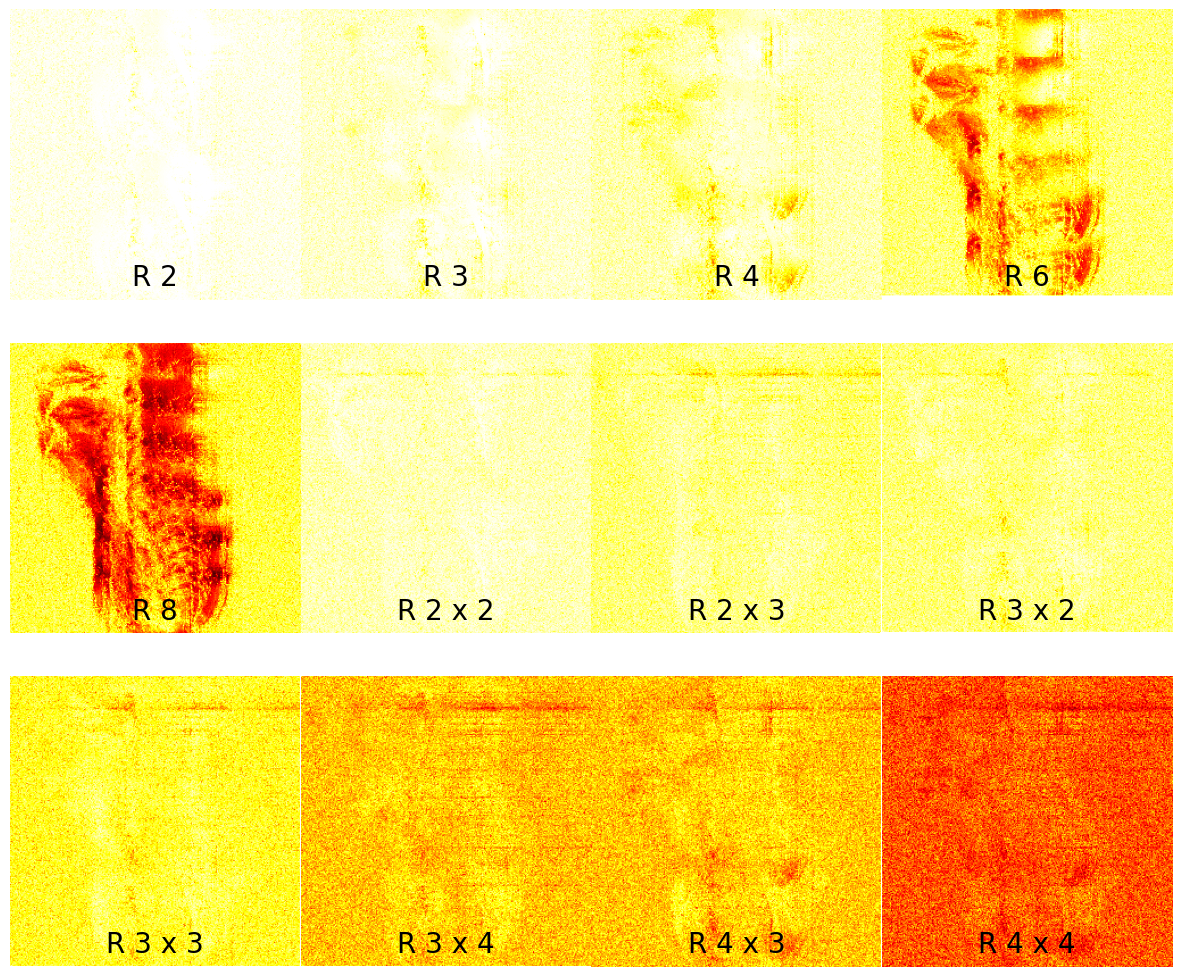

In [151]:
## Step 7: Visualising the 1/g factor map (like with the GRE scan)
numberofrows=3
numberofcolumns=4

fig=plt.figure(figsize=(15, 13))
text_for_figure=['R 2','R 3', 'R 4', 'R 6', 'R 8', 'R 2 x 2',
                 'R 2 x 3', 'R 3 x 2', 'R 3 x 3', 'R 3 x 4', 'R 4 x 3', 'R 4 x 4']
ax = fig.subplots(numberofrows,numberofcolumns,squeeze=True)
for rowindex in range(numberofrows):
    for columnindex in range(numberofcolumns):
        indexoffigure=rowindex*numberofcolumns+columnindex
        #read in files
        data_to_plot=(nib.load(GFACTOR_split_cropped_name[indexoffigure])).get_fdata() #load in nifti object, get only image data
        data_to_plot=np.rot90(data_to_plot[:,:,int(np.ceil(data_to_plot.shape[2]/2))]) #central slice
        ax[rowindex,columnindex].imshow(data_to_plot,cmap=plt.cm.hot,clim=[0, 1000])
        ax[rowindex,columnindex].text(0.5, 0.05, text_for_figure[indexoffigure],horizontalalignment='center', transform=ax[rowindex,columnindex].transAxes,color='black',fontsize=20)
        ax[rowindex,columnindex].axis('off')

plt.axis('off')
plt.subplots_adjust(hspace=0,wspace=0)
#fig.tight_layout()

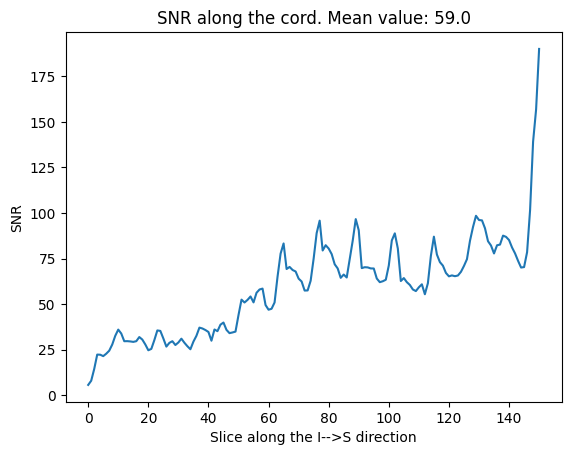

In [152]:
# Step 8: Plotting the SNR

SNR_along_cord = signal_extractor_from_csv(COILQA_SAG_LARGE_SNR_OPT_CSV)
SNR_along_cord = SNR_along_cord[~np.isnan(SNR_along_cord)]

plt.plot(SNR_along_cord)
SNR_along_cord_mean = np.round(np.mean(SNR_along_cord))
titlestring = f"SNR along the cord. Mean value: {SNR_along_cord_mean}"
plt.title(titlestring)
plt.xlabel('Slice along the I-->S direction')
plt.ylabel('SNR')
plt.show()